## Import Packages

In [415]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import operator
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import chi2, mutual_info_regression
import seaborn as sns
from sklearn.utils import resample
import pickle
%matplotlib inline

## Prepare the Data

In [441]:
bank = pd.read_csv('bank-additional-full.csv', sep=';')

## Classification Experiment


In [513]:
SEED = 1234

class BankDataProcessPipeline(object):
    def __init__(self, df, classifier=None, option='normalize'):
        self.seed = SEED
        self.split_ratio = SPLIT_RATIO
        self.option = option
        self.classifier = classifier
        self.df = df
        self.X = self.df.iloc[:,:20]
        self.df.y = self.df.y.replace('no', 0)
        self.df.y = self.df.y.replace('yes',1)
        self.y = self.df.y
        self.categorical_cols = self.X.columns[self.X.dtypes==object]
        self.numerical_cols = self.X.columns[self.X.dtypes!=object]
        self.integrate_cat_nume()

    def custom_split(self, X, y, train_index, test_index):
        return X.take(train_index).reset_index(drop=True), \
               X.take(test_index).reset_index(drop=True), \
               y.take(train_index).reset_index(drop=True), \
               y.take(test_index).reset_index(drop=True)
    
    def feature_select(self, pickle_path):
        with open(pickle_path, 'rb') as f:
            data = pickle.load(f)
        feature_selected_X = pd.concat([pd.DataFrame(data['categorical'], 
                                columns=['categorical_{}'.format(i) for i in range(data['categorical'].shape[1])]), 
                             pd.DataFrame(data['numerical'], 
                                columns=['numerical_{}'.format(i) for i in range(data['numerical'].shape[1])])], axis=1)
        return feature_selected_X
        
    
    def scale(self, cols, range_=(0,1)):
        min_max_scaler_p = MinMaxScaler(feature_range=range_)
        return min_max_scaler_p.fit_transform(self.X[cols])
    
    def one_hot_categorical(self):
        one_hot_encoded_cat = pd.DataFrame()
        for col in self.categorical_cols:
             one_hot_encoded_cat = pd.concat([one_hot_encoded_cat, pd.get_dummies(self.X[col] ,prefix='{}_is'.format(col))], axis=1)
        return one_hot_encoded_cat
        
    def normalize_numerical(self):
        # normalize numerical
        bank_numericals = self.X[self.numerical_cols]
        p_mask = list(map(lambda x: all(bank_numericals[x]>=0), self.numerical_cols))
        n_mask = list(map(lambda x: all(bank_numericals[x]<0), self.numerical_cols))
        p_n_mask = list(map(lambda x: not(all(bank_numericals[x]>=0) or 
                                          all(bank_numericals[x]<0)), self.numerical_cols))
        p_cols = self.numerical_cols[p_mask]
        n_cols = self.numerical_cols[n_mask]
        p_n_cols = self.numerical_cols[p_n_mask]
        scaled_p = pd.DataFrame(self.scale(p_cols), columns=p_cols)
        scaled_n = pd.DataFrame(self.scale(n_cols, range_=(-1,0)), columns=n_cols)
        scaled_p_n = pd.DataFrame(self.scale(p_n_cols, range_=(-1,1)), columns=p_n_cols)
        scaled_bank_numericals = pd.concat([scaled_p, scaled_n, scaled_p_n], axis=1)
        return scaled_bank_numericals
    
    def integrate_cat_nume(self):
        if self.option == 'normalize':
            self.X = pd.concat([self.one_hot_categorical(), self.normalize_numerical()], axis=1)
        else:
            self.X = pd.concat([self.one_hot_categorical(), self.X[self.numerical_cols]], axis=1)
        
    def check_imbalance(self):
        no_cnt = self.y[self.y==0].shape[0]
        yes_cnt = self.y[self.y==1].shape[0]
        print('There are {} data entries labeled as yes, {} data entries labeled as no.'.format(yes_cnt, no_cnt))
        sns.countplot("y",data=pd.DataFrame(self.y, columns=['y']))
        plt.show()
        
    def fit(self, X_train, y_train):
        self.classifier.fit(X_train, y_train)

    def predict(self, X_test):
        return self.classifier.predict(X_test)
    
    def plot_cm(self, cm, title='Confusion matrix', cmap=plt.cm.Blues):
        sns.heatmap(cm, cmap=cmap, annot=True)
        plt.show()

    def eval_results(self, predicted_y_test, y_test):
        accuracy_s = accuracy_score(y_test, predicted_y_test)
        precision_s = precision_score(y_test, predicted_y_test, average='weighted')
        recall_s = recall_score(y_test, predicted_y_test, average='weighted')
        f1_s = f1_score(y_test, predicted_y_test, average='weighted')
        cm = confusion_matrix(y_test, predicted_y_test)  
        print("Accuracy Score:", accuracy_s)
        print("Precision Score:", precision_s)
        print("Recall Score:", recall_s)
        print("f1 Score:", f1_s)
        print('confusion_matrix is: \n', cm, '\n')
        return accuracy_s, precision_s, recall_s, f1_s, cm
    
    def resample(self, X_train, y_train, fold, option, downratio=1, upratio=1):
        tmp_df = pd.concat([X_train, y_train], axis=1)
        no_idx = tmp_df[tmp_df.y==0].index
        yes_idx = tmp_df[tmp_df.y==1].index
        df_majority = tmp_df.iloc[no_idx,:]
        df_minority = tmp_df.iloc[yes_idx,:]
        majority_cnt = df_majority.shape[0]
        minority_cnt = df_minority.shape[0]
        if option == 'downsample':
            df_majority_downsampled = resample(df_majority, 
                                                 replace=False,    
                                                 n_samples=minority_cnt*downratio,     
                                                 random_state=self.seed)
            df_downsampled = pd.concat([df_majority_downsampled, df_minority], axis=0)
            if fold == 1:
                print('After downsampling, there are {} data entries labeled as yes.\n There are {} data entries labeled as no.'.format(len(df_downsampled[df_downsampled.y==1]), 
                                                                                           len(df_downsampled[df_downsampled.y==0])))
                
                plt.figure(figsize=(5,5))
                sns.countplot("y",data=df_downsampled)
                plt.show()
            return df_downsampled.iloc[:, :-1], df_downsampled.y
        elif option == 'upsample':
            df_minority_upsampled = resample(df_minority, 
                                                 replace=True,    
                                                 n_samples=int(majority_cnt*upratio),     
                                                 random_state=self.seed)
            df_upsampled = pd.concat([df_minority_upsampled, df_majority])
            if fold == 1:
                print('After upsampling, there are {} data entries labeled as yes.\n There are {} data entries labeled as no.'.format(len(df_upsampled[df_upsampled.y==1]), 
                                                                                           len(df_upsampled[df_upsampled.y==0])))
                plt.figure(figsize=(5,5))
                sns.countplot("y",data=df_upsampled)
                plt.show()
            return df_upsampled.iloc[:, :-1], df_upsampled.y
        else:
            return X_train, y_train

    
    def k_fold_cross_val(self, fold, option='noresample', downratio=1, upratio=1, feature_engineered=False, topK=None):
        # initialization
        f = 1
        accuracy = []
        precision = []
        recall=[]
        f1=[]
        
        if feature_engineered:
            X = self.feature_select(pickle_path='feature_selection/feature_k={}.pkl'.format(topK)) 
        else:
            X = self.X
        y = self.y
        skf = StratifiedKFold(n_splits=fold, random_state=1, shuffle= True)

        print('The shape of training set is: ', X.shape, '\n')
        for train_index, test_index in skf.split(X, y):
            X_train, X_test, y_train, y_test = self.custom_split(X, y, train_index, test_index)
            X_train, y_train = self.resample(X_train, pd.DataFrame(y_train, columns=['y']), fold=f, option=option, downratio=downratio, upratio=upratio)
            
            self.fit(X_train, y_train)
            predicted_y_test = self.predict(X_test)
            accuracy_s, precision_s, recall_s, f1_s, cm = self.eval_results(predicted_y_test, y_test)
            
            accuracy.append(accuracy_s)
            precision.append(precision_s)
            recall.append(recall_s)
            f1.append(f1_s)
            self.plot_cm(cm)
            f += 1

        metrics_df = pd.DataFrame(
            {'accuracy': accuracy,
            'precision': precision,
            'recall':recall,
            'f1':f1}
        )
        metrics_df.plot()
        return metrics_df

## Task 1

In this task, you will train a logistic regression classifier on Bank
Marketing Dataset to predict whether a client will subscribe a term deposit.

- There are 10 numerical features and 10 categorical features. Please train
Logistic Regression Model 1 based on normalized numerical features and
one-hot encoded categorical features, and train Logistic Regression
Model 2 based on unnormalized numerical feature and one-hot encoded
categorical feature.

- Please use 5-Fold cross-validation for experiments. (See textbook and
https://en.wikipedia.org/wiki/Cross-validation_(statistics))
Please summarize the definitions and mathematical formulae of confusion matrix,
precision metric, recall metric, f-measure metric, and accuracy metric. Please
compare the performance of Logistic Regression Model 1 and Logistic
Regression Model 2 in terms of these four metrics.

In [444]:
classifier = LogisticRegression(random_state=SEED, solver='lbfgs', multi_class='multinomial')

### Logistic Regression Model 1 :  normalized numerical features and one-hot encoded categorical features

The shape of training set is:  (41188, 63) 

Accuracy Score: 0.9045884923525127
Precision Score: 0.8914170715706206
Recall Score: 0.9045884923525127
f1 Score: 0.8941819489385229
confusion_matrix is: 
 [[7098  212]
 [ 574  354]] 



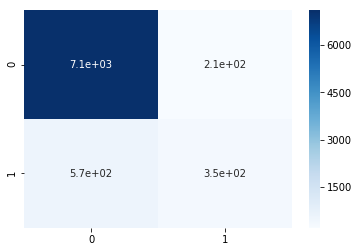

Accuracy Score: 0.9124787569798495
Precision Score: 0.9017988146093208
Recall Score: 0.9124787569798495
f1 Score: 0.9032987735403986
confusion_matrix is: 
 [[7125  185]
 [ 536  392]] 



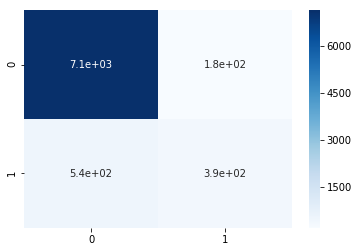

Accuracy Score: 0.911143481427531
Precision Score: 0.8997420216034089
Recall Score: 0.911143481427531
f1 Score: 0.901039679440525
confusion_matrix is: 
 [[7131  179]
 [ 553  375]] 



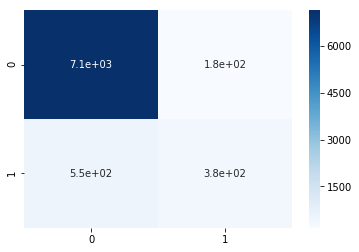

Accuracy Score: 0.9100400631297803
Precision Score: 0.8985023212228005
Recall Score: 0.9100400631297803
f1 Score: 0.9002627150042405
confusion_matrix is: 
 [[7119  190]
 [ 551  377]] 



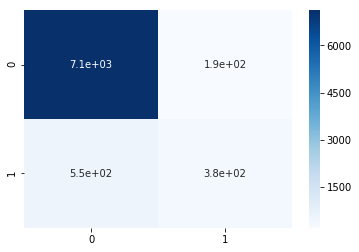

Accuracy Score: 0.9155032171907248
Precision Score: 0.9054994891484598
Recall Score: 0.9155032171907248
f1 Score: 0.9060267271213339
confusion_matrix is: 
 [[7146  163]
 [ 533  395]] 



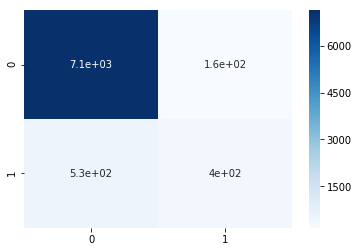

,accuracy,precision,recall,f1
0,0.904588,0.891417,0.904588,0.894182
1,0.912479,0.901799,0.912479,0.903299
2,0.911143,0.899742,0.911143,0.901040
3,0.910040,0.898502,0.910040,0.900263
4,0.915503,0.905499,0.915503,0.906027


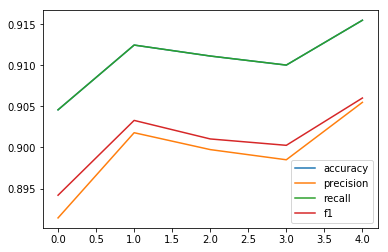

In [458]:
bdpp_logistic = BankDataProcessPipeline(bank, classifier)
bdpp_logistic.k_fold_cross_val(fold=5)

### Logistic Regression Model 2 : unnormalized numerical features and one-hot encoded categorical features

The shape of training set is:  (41188, 63) 

Accuracy Score: 0.9026462733673222
Precision Score: 0.8891176822614446
Recall Score: 0.9026462733673222
f1 Score: 0.8923245988554434
confusion_matrix is: 
 [[7086  224]
 [ 578  350]] 



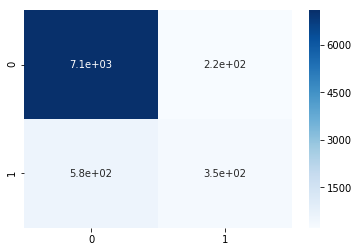

Accuracy Score: 0.9119932022335518
Precision Score: 0.9011766970036472
Recall Score: 0.9119932022335518
f1 Score: 0.9027622896210665
confusion_matrix is: 
 [[7123  187]
 [ 538  390]] 



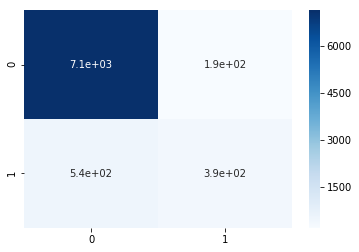

Accuracy Score: 0.9109007040543822
Precision Score: 0.8990401449786506
Recall Score: 0.9109007040543822
f1 Score: 0.8995575335185689
confusion_matrix is: 
 [[7147  163]
 [ 571  357]] 



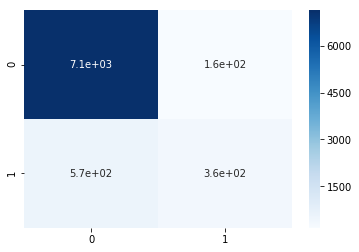

Accuracy Score: 0.9107684836712395
Precision Score: 0.899414228649288
Recall Score: 0.9107684836712395
f1 Score: 0.901001918598974
confusion_matrix is: 
 [[7123  186]
 [ 549  379]] 



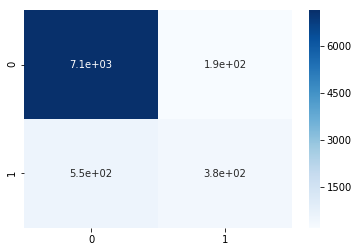

Accuracy Score: 0.9123467281777347
Precision Score: 0.9015874832747861
Recall Score: 0.9123467281777347
f1 Score: 0.9030536574485508
confusion_matrix is: 
 [[7125  184]
 [ 538  390]] 



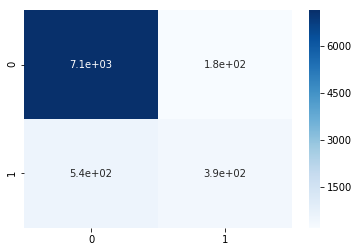

,accuracy,precision,recall,f1
0,0.902646,0.889118,0.902646,0.892325
1,0.911993,0.901177,0.911993,0.902762
2,0.910901,0.899040,0.910901,0.899558
3,0.910768,0.899414,0.910768,0.901002
4,0.912347,0.901587,0.912347,0.903054


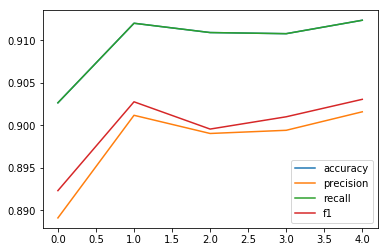

In [459]:
bdpp_logistic = BankDataProcessPipeline(bank, classifier, option='unnormalize')
bdpp_logistic.k_fold_cross_val(fold=5)

## Task 2
Imbalanced Issue

Note that data imbalance exists in this dataset. 

- Please explain why we
want to avoid imbalance issue in training classifiers? 

- Briefly summarize at least 3
methods deal with data imbalance issue. 

- Generate new datasets by either
downsampling or upsampling and repeat the steps in Task 1 to compare the
performance of generated datasets with the original dataset. 

- Note that you only
need to perform sampling algorithms on training set. Please explain why. 

In [486]:
bdpp_logistic = BankDataProcessPipeline(bank, classifier)

There are 4640 data entries labeled as yes, 36548 data entries labeled as no.


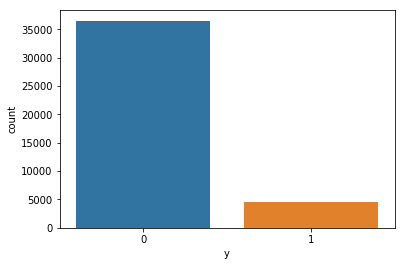

In [461]:
bdpp_logistic.check_imbalance()

For instance, choose one fold from Logistic Regression Model 1, 

- Accuracy Score: 0.9045884923525127
- Precision Score: 0.8914170715706206
- Recall Score: 0.9045884923525127
- f1 Score: 0.8941819489385229

- confusion_matrix is:

```
[[7098  212]

[ 574  354]] 
```

Here we can see from the confusion matrix that the `True Negative`=7098, and `False Positive`=212, which means all 33 `Irrelevant` tweets are categorized as `Relevant`. Thus there appears to have a serious problem here: even with the accuracy is decent, it is actually inflated. The reason for that is because the proportion of `Relevant` tweets(__1133/1296__) is way larger than that of `Irrelevant` tweets(__163/1296__), thus

$$accuracy = \frac{TP+TN}{TP+TN+FN+FP} = \frac{227}{260} = 87.3\%$$

In fact, with the task being to filter out the irrelevant tweets, this classifier basically fails the task because of the unbalanced data.

### Downsampling

The shape of training set is:  (41188, 63) 

After downsampling, there are 3712 data entries labeled as yes.
 There are 3712 data entries labeled as no.


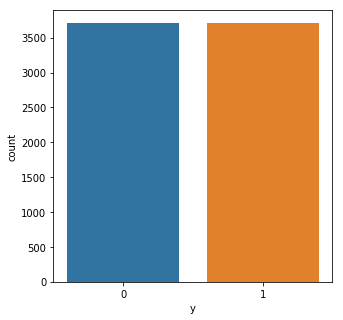

Accuracy Score: 0.8561544064093226
Precision Score: 0.9187909683449437
Recall Score: 0.8561544064093226
f1 Score: 0.8753809330559901
confusion_matrix is: 
 [[6248 1062]
 [ 123  805]] 



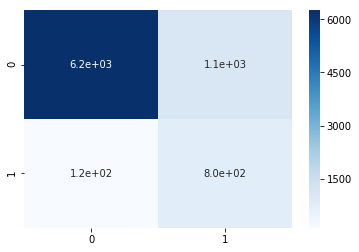

Accuracy Score: 0.8580966253945133
Precision Score: 0.9186882478809587
Recall Score: 0.8580966253945133
f1 Score: 0.8767882618609042
confusion_matrix is: 
 [[6268 1042]
 [ 127  801]] 



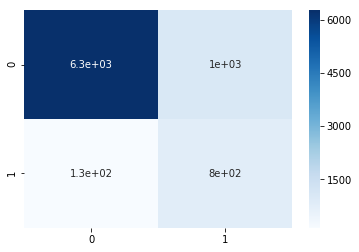

Accuracy Score: 0.8663510560815731
Precision Score: 0.9236642118129516
Recall Score: 0.8663510560815731
f1 Score: 0.883666449975388
confusion_matrix is: 
 [[6315  995]
 [ 106  822]] 



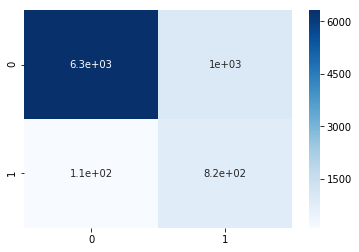

Accuracy Score: 0.8579579944154425
Precision Score: 0.9193560577924251
Recall Score: 0.8579579944154425
f1 Score: 0.8767944211730492
confusion_matrix is: 
 [[6261 1048]
 [ 122  806]] 



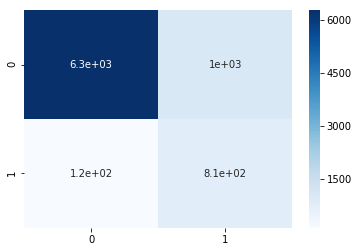

Accuracy Score: 0.8603860628869734
Precision Score: 0.9219200899761449
Recall Score: 0.8603860628869734
f1 Score: 0.8789904666862631
confusion_matrix is: 
 [[6267 1042]
 [ 108  820]] 



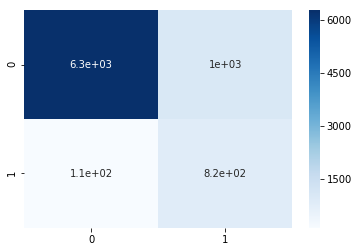

,accuracy,precision,recall,f1
0,0.856154,0.918791,0.856154,0.875381
1,0.858097,0.918688,0.858097,0.876788
2,0.866351,0.923664,0.866351,0.883666
3,0.857958,0.919356,0.857958,0.876794
4,0.860386,0.921920,0.860386,0.878990


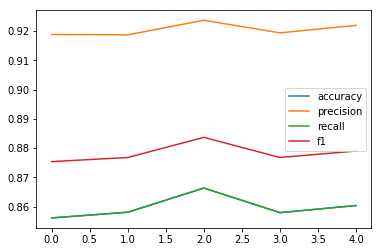

In [476]:
bdpp_logistic.k_fold_cross_val(fold=5, option='downsample')

The shape of training set is:  (41188, 63) 

After downsampling, there are 3712 data entries labeled as yes.
 There are 7424 data entries labeled as no.


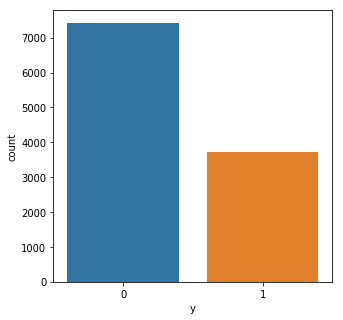

Accuracy Score: 0.8885651857246905
Precision Score: 0.9121440976603549
Recall Score: 0.8885651857246905
f1 Score: 0.8972307872085865
confusion_matrix is: 
 [[6640  670]
 [ 248  680]] 



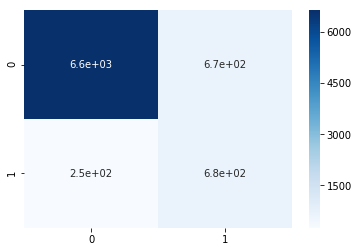

Accuracy Score: 0.8896576839038601
Precision Score: 0.9143480431269377
Recall Score: 0.8896576839038601
f1 Score: 0.8985647738195354
confusion_matrix is: 
 [[6634  676]
 [ 233  695]] 



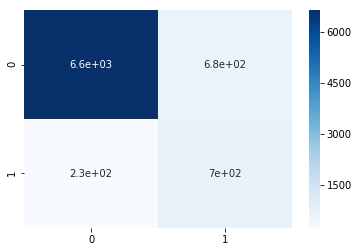

Accuracy Score: 0.8976693372177713
Precision Score: 0.9193539679969821
Recall Score: 0.8976693372177713
f1 Score: 0.9054358983311109
confusion_matrix is: 
 [[6684  626]
 [ 217  711]] 



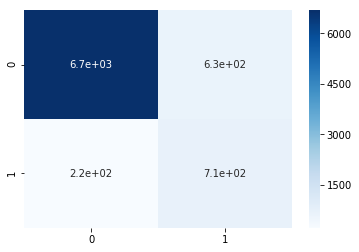

Accuracy Score: 0.8936506009469467
Precision Score: 0.9162403341467596
Recall Score: 0.8936506009469467
f1 Score: 0.9018292388987219
confusion_matrix is: 
 [[6663  646]
 [ 230  698]] 



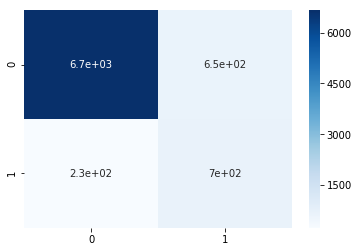

Accuracy Score: 0.8913439358989923
Precision Score: 0.917487246003501
Recall Score: 0.8913439358989923
f1 Score: 0.9005315261981561
confusion_matrix is: 
 [[6626  683]
 [ 212  716]] 



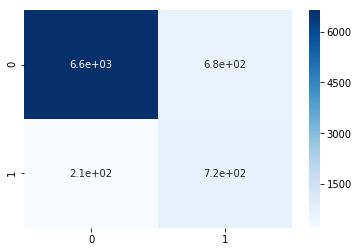

,accuracy,precision,recall,f1
0,0.888565,0.912144,0.888565,0.897231
1,0.889658,0.914348,0.889658,0.898565
2,0.897669,0.919354,0.897669,0.905436
3,0.893651,0.916240,0.893651,0.901829
4,0.891344,0.917487,0.891344,0.900532


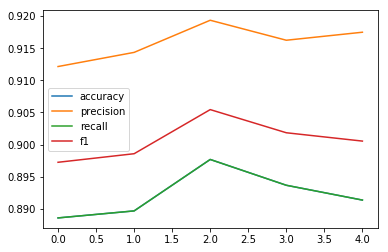

In [480]:
bdpp_logistic.k_fold_cross_val(fold=5, option='downsample', downratio=2)

The shape of training set is:  (41188, 63) 

After downsampling, there are 3712 data entries labeled as yes.
 There are 11136 data entries labeled as no.


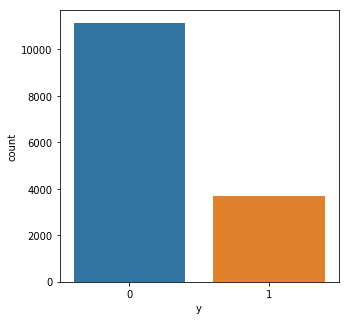

Accuracy Score: 0.8996115562029618
Precision Score: 0.9083935701068496
Recall Score: 0.8996115562029618
f1 Score: 0.9033665046970193
confusion_matrix is: 
 [[6808  502]
 [ 325  603]] 



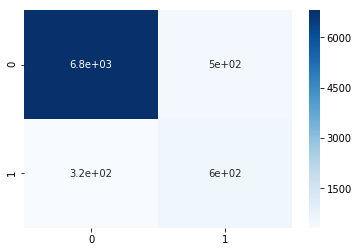

Accuracy Score: 0.9039815489196407
Precision Score: 0.911462762622082
Recall Score: 0.9039815489196407
f1 Score: 0.9072047807483384
confusion_matrix is: 
 [[6836  474]
 [ 317  611]] 



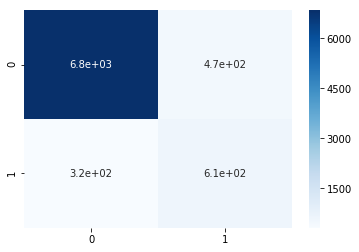

Accuracy Score: 0.9090798737557659
Precision Score: 0.9166358150031702
Recall Score: 0.9090798737557659
f1 Score: 0.9122724437836849
confusion_matrix is: 
 [[6853  457]
 [ 292  636]] 



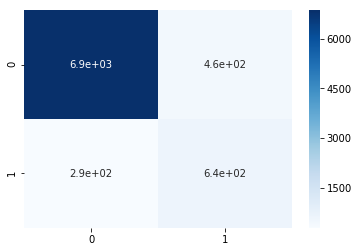

Accuracy Score: 0.9048197159159889
Precision Score: 0.9129983356889143
Recall Score: 0.9048197159159889
f1 Score: 0.9082893329576954
confusion_matrix is: 
 [[6831  478]
 [ 306  622]] 



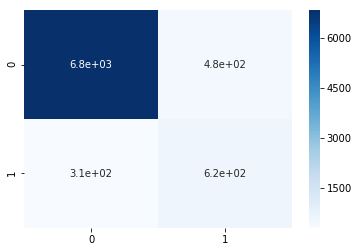

Accuracy Score: 0.9060337501517542
Precision Score: 0.9154353417779709
Recall Score: 0.9060337501517542
f1 Score: 0.9099176733352561
confusion_matrix is: 
 [[6823  486]
 [ 288  640]] 



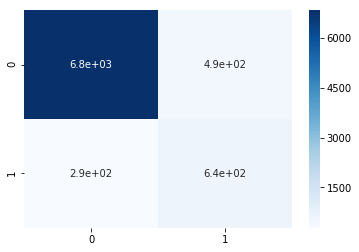

,accuracy,precision,recall,f1
0,0.899612,0.908394,0.899612,0.903367
1,0.903982,0.911463,0.903982,0.907205
2,0.909080,0.916636,0.909080,0.912272
3,0.904820,0.912998,0.904820,0.908289
4,0.906034,0.915435,0.906034,0.909918


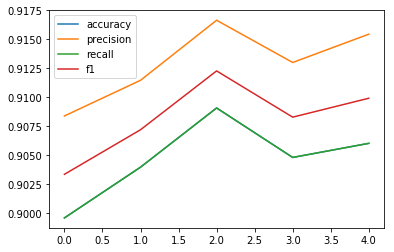

In [481]:
bdpp_logistic.k_fold_cross_val(fold=5, option='downsample', downratio=3)

### Upsampling

The shape of training set is:  (41188, 63) 

After upsampling, there are 29238 data entries labeled as yes.
 There are 29238 data entries labeled as no.


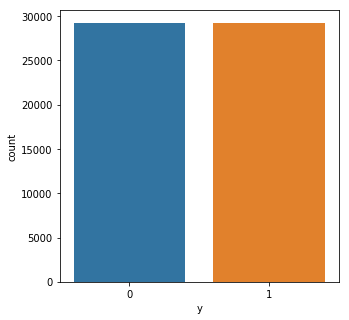

Accuracy Score: 0.8543335761107065
Precision Score: 0.9205137643326631
Recall Score: 0.8543335761107065
f1 Score: 0.8743129605915115
confusion_matrix is: 
 [[6218 1092]
 [ 108  820]] 



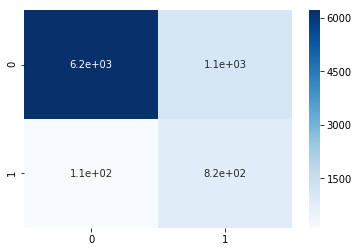

Accuracy Score: 0.8573682932750668
Precision Score: 0.9197890508243036
Recall Score: 0.8573682932750668
f1 Score: 0.8764325707517202
confusion_matrix is: 
 [[6253 1057]
 [ 118  810]] 



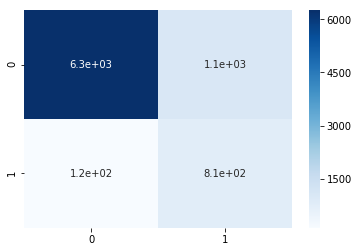

Accuracy Score: 0.8651371692158291
Precision Score: 0.9236425859702262
Recall Score: 0.8651371692158291
f1 Score: 0.8827679068612164
confusion_matrix is: 
 [[6303 1007]
 [ 104  824]] 



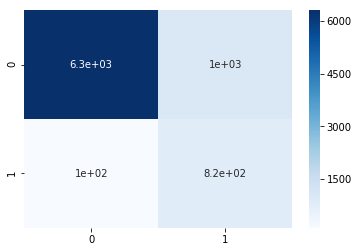

Accuracy Score: 0.8600218526162438
Precision Score: 0.9208421196175186
Recall Score: 0.8600218526162438
f1 Score: 0.8785505500835222
confusion_matrix is: 
 [[6271 1038]
 [ 115  813]] 



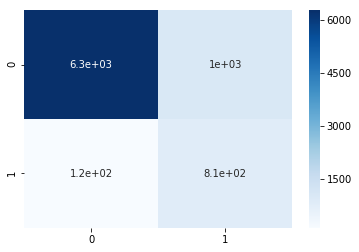

Accuracy Score: 0.8630569382056574
Precision Score: 0.9231283003801376
Recall Score: 0.8630569382056574
f1 Score: 0.8811504727490317
confusion_matrix is: 
 [[6285 1024]
 [ 104  824]] 



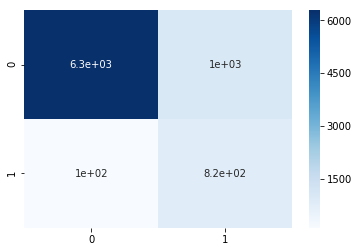

,accuracy,precision,recall,f1
0,0.854334,0.920514,0.854334,0.874313
1,0.857368,0.919789,0.857368,0.876433
2,0.865137,0.923643,0.865137,0.882768
3,0.860022,0.920842,0.860022,0.878551
4,0.863057,0.923128,0.863057,0.881150


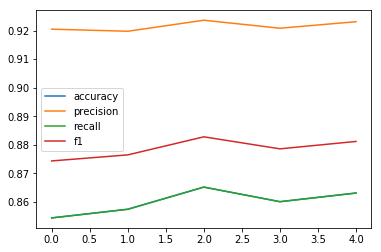

In [482]:
bdpp_logistic.k_fold_cross_val(fold=5, option='upsample')

The shape of training set is:  (41188, 63) 

After upsampling, there are 20466 data entries labeled as yes.
 There are 29238 data entries labeled as no.


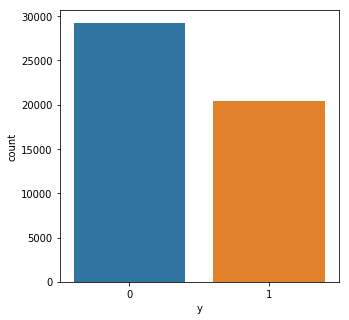

Accuracy Score: 0.8708424374848264
Precision Score: 0.9173373008018841
Recall Score: 0.8708424374848264
f1 Score: 0.8858336520349598
confusion_matrix is: 
 [[6407  903]
 [ 161  767]] 



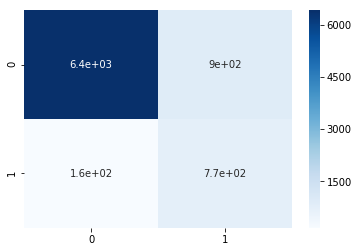

Accuracy Score: 0.8742413207089099
Precision Score: 0.9179147603053871
Recall Score: 0.8742413207089099
f1 Score: 0.8884042460922066
confusion_matrix is: 
 [[6438  872]
 [ 164  764]] 



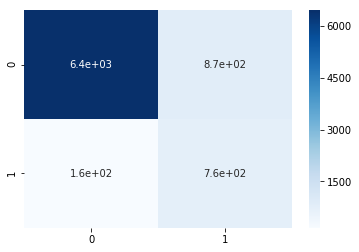

Accuracy Score: 0.8806749210973537
Precision Score: 0.922058806871543
Recall Score: 0.8806749210973537
f1 Score: 0.8938763839207587
confusion_matrix is: 
 [[6474  836]
 [ 147  781]] 



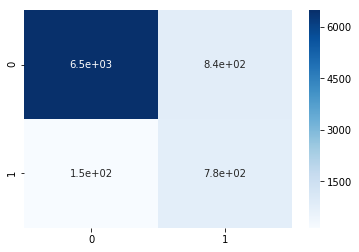

Accuracy Score: 0.8784751729998787
Precision Score: 0.9189104324006808
Recall Score: 0.8784751729998787
f1 Score: 0.8916600132236561
confusion_matrix is: 
 [[6474  835]
 [ 166  762]] 



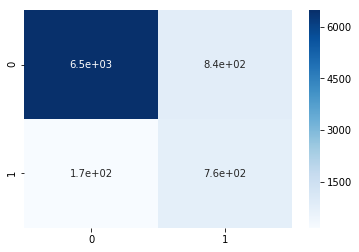

Accuracy Score: 0.8783537695763021
Precision Score: 0.9209660467925451
Recall Score: 0.8783537695763021
f1 Score: 0.8919773944285228
confusion_matrix is: 
 [[6457  852]
 [ 150  778]] 



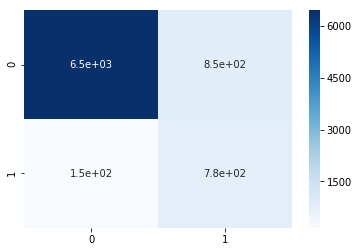

,accuracy,precision,recall,f1
0,0.870842,0.917337,0.870842,0.885834
1,0.874241,0.917915,0.874241,0.888404
2,0.880675,0.922059,0.880675,0.893876
3,0.878475,0.918910,0.878475,0.891660
4,0.878354,0.920966,0.878354,0.891977


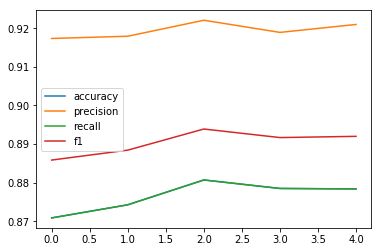

In [491]:
bdpp_logistic.k_fold_cross_val(fold=5, option='upsample', upratio=0.7)

The shape of training set is:  (41188, 63) 

After upsampling, there are 14619 data entries labeled as yes.
 There are 29238 data entries labeled as no.


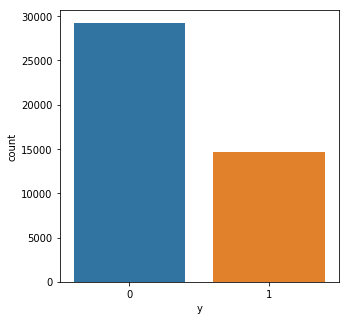

Accuracy Score: 0.8871085214857976
Precision Score: 0.9142422809736062
Recall Score: 0.8871085214857976
f1 Score: 0.8967606639130317
confusion_matrix is: 
 [[6606  704]
 [ 226  702]] 



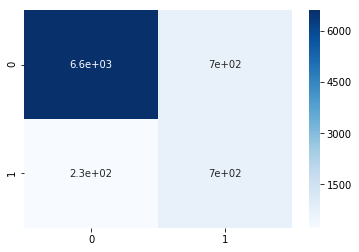

Accuracy Score: 0.888443797038116
Precision Score: 0.9149742865370206
Recall Score: 0.888443797038116
f1 Score: 0.8978768757947186
confusion_matrix is: 
 [[6615  695]
 [ 224  704]] 



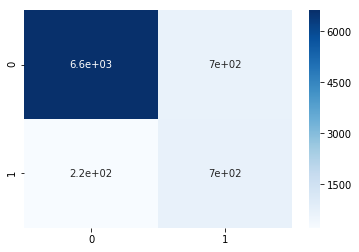

Accuracy Score: 0.8976693372177713
Precision Score: 0.9198152147303434
Recall Score: 0.8976693372177713
f1 Score: 0.9055538119773321
confusion_matrix is: 
 [[6680  630]
 [ 213  715]] 



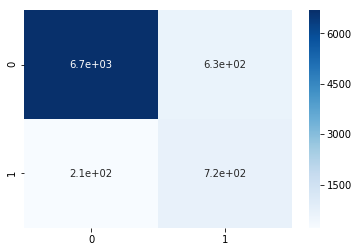

Accuracy Score: 0.8951074420298653
Precision Score: 0.9169348346170508
Recall Score: 0.8951074420298653
f1 Score: 0.9030226224788552
confusion_matrix is: 
 [[6674  635]
 [ 229  699]] 



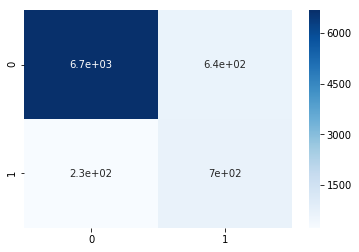

Accuracy Score: 0.893043583829064
Precision Score: 0.9188400801662147
Recall Score: 0.893043583829064
f1 Score: 0.9020585770964724
confusion_matrix is: 
 [[6634  675]
 [ 206  722]] 



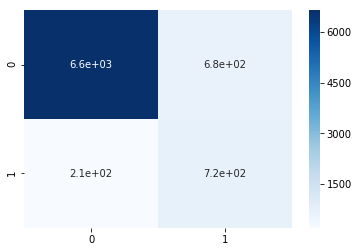

,accuracy,precision,recall,f1
0,0.887109,0.914242,0.887109,0.896761
1,0.888444,0.914974,0.888444,0.897877
2,0.897669,0.919815,0.897669,0.905554
3,0.895107,0.916935,0.895107,0.903023
4,0.893044,0.918840,0.893044,0.902059


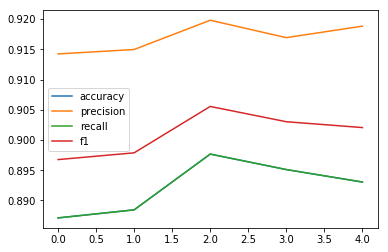

In [492]:
bdpp_logistic.k_fold_cross_val(fold=5, option='upsample', upratio=0.5)

The shape of training set is:  (41188, 63) 

After upsampling, there are 8771 data entries labeled as yes.
 There are 29238 data entries labeled as no.


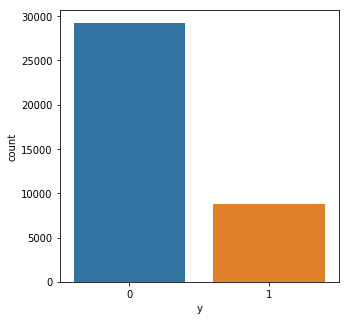

Accuracy Score: 0.9025248846807478
Precision Score: 0.9079022599746283
Recall Score: 0.9025248846807478
f1 Score: 0.9049422770328267
confusion_matrix is: 
 [[6852  458]
 [ 345  583]] 



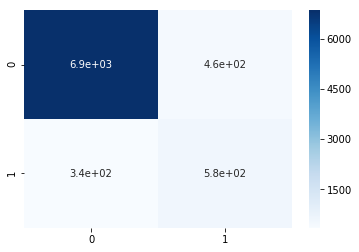

Accuracy Score: 0.9060451565914057
Precision Score: 0.911019587289107
Recall Score: 0.9060451565914057
f1 Score: 0.9082788249374741
confusion_matrix is: 
 [[6869  441]
 [ 333  595]] 



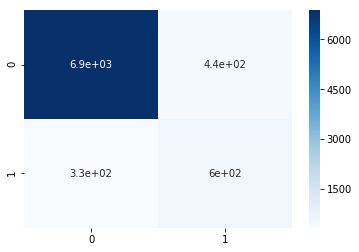

Accuracy Score: 0.9113862588006798
Precision Score: 0.9150312981633852
Recall Score: 0.9113862588006798
f1 Score: 0.913048662017654
confusion_matrix is: 
 [[6903  407]
 [ 323  605]] 



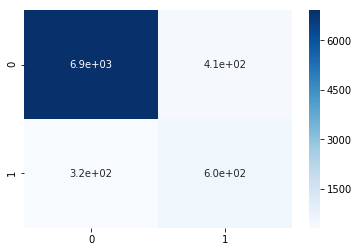

Accuracy Score: 0.9076119946582494
Precision Score: 0.9117178232952308
Recall Score: 0.9076119946582494
f1 Score: 0.9094816680202243
confusion_matrix is: 
 [[6883  426]
 [ 335  593]] 



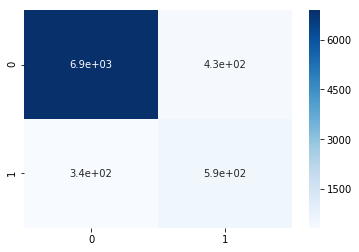

Accuracy Score: 0.9104042734005099
Precision Score: 0.9158350826556605
Recall Score: 0.9104042734005099
f1 Score: 0.9127903127988446
confusion_matrix is: 
 [[6879  430]
 [ 308  620]] 



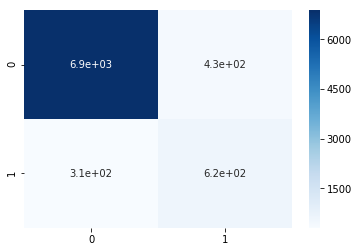

,accuracy,precision,recall,f1
0,0.902525,0.907902,0.902525,0.904942
1,0.906045,0.911020,0.906045,0.908279
2,0.911386,0.915031,0.911386,0.913049
3,0.907612,0.911718,0.907612,0.909482
4,0.910404,0.915835,0.910404,0.912790


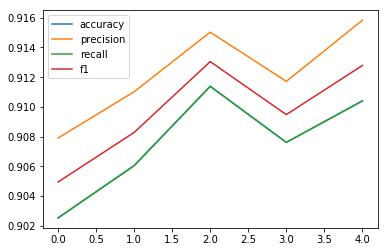

In [493]:
bdpp_logistic.k_fold_cross_val(fold=5, option='upsample', upratio=0.3)

## Task 3

Feature Selection

- Please summary the reason why we perform feature selection? 
- Please perform feature selection based on the correlation results in Assignment 1 (using
chi-square for categorical data and mutual information for numerical data).
- Generate partial datasets by only using top k (k =1, 3, 5) most correlated
categorical features and numerical features for model training (i.e., k categorical
features + k numerical features). 
Follow the setup in Task 1 to compare the
performance of partial datasets with the original dataset.

The shape of training set is:  (41188, 4) 

Accuracy Score: 0.8895362952172857
Precision Score: 0.8593619997792195
Recall Score: 0.8895362952172857
f1 Score: 0.8597705492620276
confusion_matrix is: 
 [[7197  113]
 [ 797  131]] 



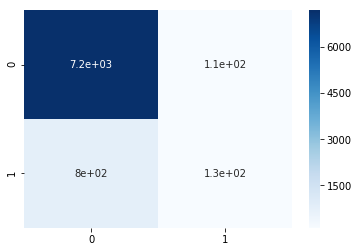

Accuracy Score: 0.8934207331876669
Precision Score: 0.8685553944699733
Recall Score: 0.8934207331876669
f1 Score: 0.8661833398292561
confusion_matrix is: 
 [[7202  108]
 [ 770  158]] 



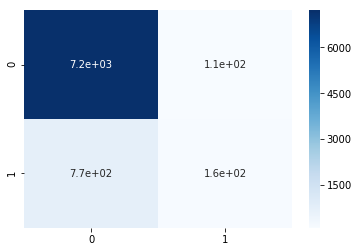

Accuracy Score: 0.894634620053411
Precision Score: 0.8716459844879313
Recall Score: 0.894634620053411
f1 Score: 0.865140509715972
confusion_matrix is: 
 [[7226   84]
 [ 784  144]] 



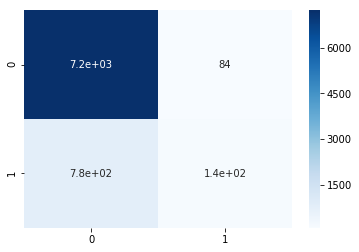

Accuracy Score: 0.8963214762656307
Precision Score: 0.8755447652942268
Recall Score: 0.8963214762656307
f1 Score: 0.8679813534027798
confusion_matrix is: 
 [[7227   82]
 [ 772  156]] 



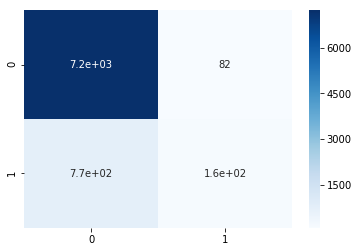

Accuracy Score: 0.8931649872526405
Precision Score: 0.867981257105622
Recall Score: 0.8931649872526405
f1 Score: 0.8655968059394417
confusion_matrix is: 
 [[7202  107]
 [ 773  155]] 



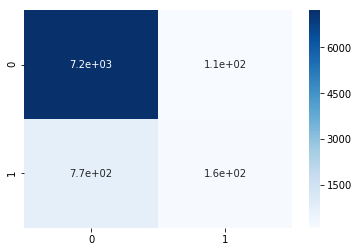

,accuracy,precision,recall,f1
0,0.889536,0.859362,0.889536,0.859771
1,0.893421,0.868555,0.893421,0.866183
2,0.894635,0.871646,0.894635,0.865141
3,0.896321,0.875545,0.896321,0.867981
4,0.893165,0.867981,0.893165,0.865597


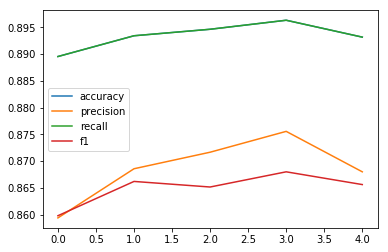

In [394]:
bdpp_logistic = BankDataProcessPipeline(bank, classifier)
bdpp_logistic.k_fold_cross_val(fold=5, feature_engineered=True, topK=1)

The shape of training set is:  (41188, 16) 

Accuracy Score: 0.8948773974265598
Precision Score: 0.8735973571585692
Recall Score: 0.8948773974265598
f1 Score: 0.8760188108622311
confusion_matrix is: 
 [[7139  171]
 [ 695  233]] 



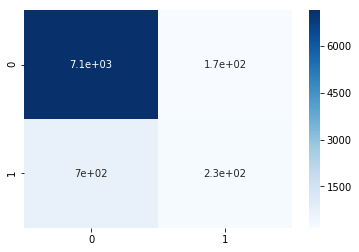

Accuracy Score: 0.9003398883224083
Precision Score: 0.8823905904622007
Recall Score: 0.9003398883224083
f1 Score: 0.8823140458672618
confusion_matrix is: 
 [[7163  147]
 [ 674  254]] 



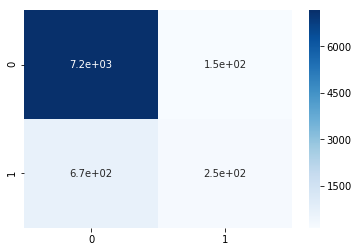

Accuracy Score: 0.9009468317552805
Precision Score: 0.8832628194028941
Recall Score: 0.9009468317552805
f1 Score: 0.881986492657514
confusion_matrix is: 
 [[7176  134]
 [ 682  246]] 



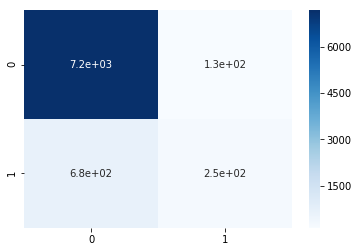

Accuracy Score: 0.9019060337501518
Precision Score: 0.8850894854308311
Recall Score: 0.9019060337501518
f1 Score: 0.8851634508720808
confusion_matrix is: 
 [[7158  151]
 [ 657  271]] 



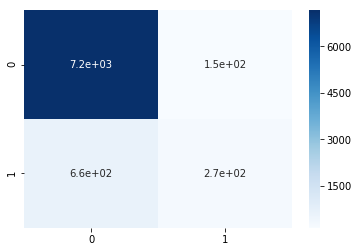

Accuracy Score: 0.9019060337501518
Precision Score: 0.8850066238655362
Recall Score: 0.9019060337501518
f1 Score: 0.8846915622341918
confusion_matrix is: 
 [[7163  146]
 [ 662  266]] 



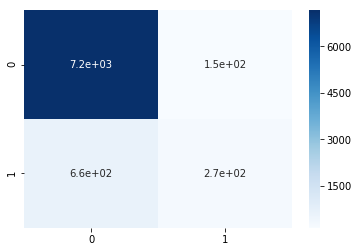

,accuracy,precision,recall,f1
0,0.894877,0.873597,0.894877,0.876019
1,0.900340,0.882391,0.900340,0.882314
2,0.900947,0.883263,0.900947,0.881986
3,0.901906,0.885089,0.901906,0.885163
4,0.901906,0.885007,0.901906,0.884692


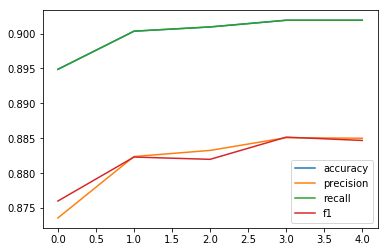

In [395]:
bdpp_logistic.k_fold_cross_val(fold=5, feature_engineered=True, topK=3)

The shape of training set is:  (41188, 33) 

Accuracy Score: 0.9032532168001942
Precision Score: 0.888880245374016
Recall Score: 0.9032532168001942
f1 Score: 0.8914474129691036
confusion_matrix is: 
 [[7109  201]
 [ 596  332]] 



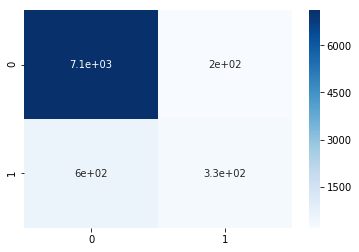

Accuracy Score: 0.9107793153678078
Precision Score: 0.8991436879850447
Recall Score: 0.9107793153678078
f1 Score: 0.9003188436342028
confusion_matrix is: 
 [[7134  176]
 [ 559  369]] 



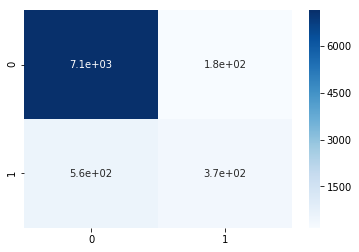

Accuracy Score: 0.9113862588006798
Precision Score: 0.8996736678918512
Recall Score: 0.9113862588006798
f1 Score: 0.8999590576895612
confusion_matrix is: 
 [[7151  159]
 [ 571  357]] 



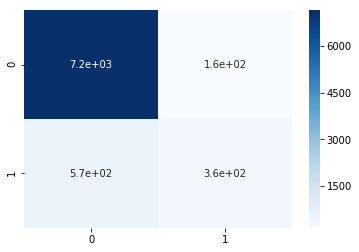

Accuracy Score: 0.909311642588321
Precision Score: 0.897031058667994
Recall Score: 0.909311642588321
f1 Score: 0.8982452944601209
confusion_matrix is: 
 [[7133  176]
 [ 571  357]] 



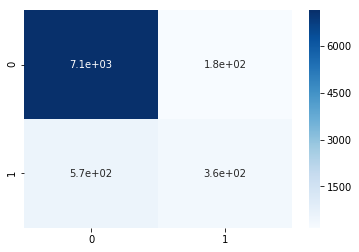

Accuracy Score: 0.9136821658370766
Precision Score: 0.9028852405338791
Recall Score: 0.9136821658370766
f1 Score: 0.9030098076721332
confusion_matrix is: 
 [[7153  156]
 [ 555  373]] 



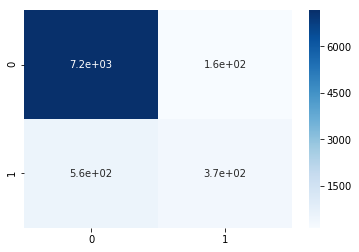

,accuracy,precision,recall,f1
0,0.903253,0.888880,0.903253,0.891447
1,0.910779,0.899144,0.910779,0.900319
2,0.911386,0.899674,0.911386,0.899959
3,0.909312,0.897031,0.909312,0.898245
4,0.913682,0.902885,0.913682,0.903010


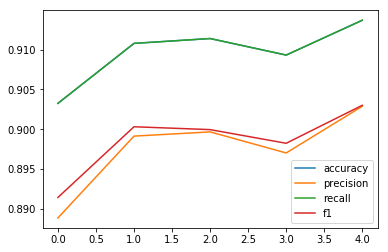

In [397]:
bdpp_logistic.k_fold_cross_val(fold=5, feature_engineered=True, topK=5)

## Task 4

Model Comparison


In addition to logistic regression classification, Decision tree and Multilayer
perceptron neural network are also widely used for classification. Please
follow the setup in Task 1 to compare the performance of these two models with
Logistic Regression Model on both balanced and imbalanced datasets.


In [516]:
lr = LogisticRegression(random_state=SEED, solver='lbfgs', multi_class='multinomial')
dt = DecisionTreeClassifier(criterion = 'entropy',
                            random_state = SEED)
mlp = MLPClassifier(random_state = SEED, max_iter=1000)

### Unbalanced Dataset

#### LogisticRegression

The shape of training set is:  (41188, 63) 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Accuracy Score: 0.9045884923525127
Precision Score: 0.8914170715706206
Recall Score: 0.9045884923525127
f1 Score: 0.8941819489385229
confusion_matrix is: 
 [[7098  212]
 [ 574  354]] 



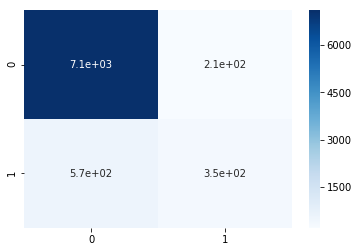

Accuracy Score: 0.9124787569798495
Precision Score: 0.9017988146093208
Recall Score: 0.9124787569798495
f1 Score: 0.9032987735403986
confusion_matrix is: 
 [[7125  185]
 [ 536  392]] 



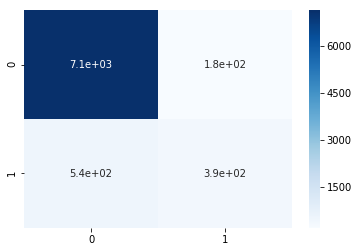

Accuracy Score: 0.911143481427531
Precision Score: 0.8997420216034089
Recall Score: 0.911143481427531
f1 Score: 0.901039679440525
confusion_matrix is: 
 [[7131  179]
 [ 553  375]] 



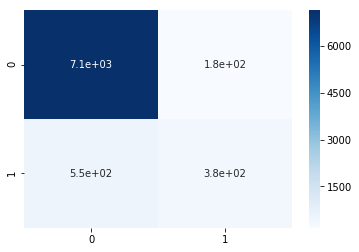

Accuracy Score: 0.9100400631297803
Precision Score: 0.8985023212228005
Recall Score: 0.9100400631297803
f1 Score: 0.9002627150042405
confusion_matrix is: 
 [[7119  190]
 [ 551  377]] 



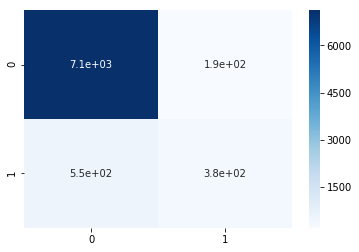

Accuracy Score: 0.9155032171907248
Precision Score: 0.9054994891484598
Recall Score: 0.9155032171907248
f1 Score: 0.9060267271213339
confusion_matrix is: 
 [[7146  163]
 [ 533  395]] 



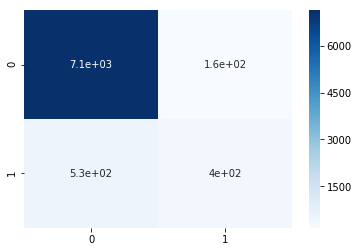

,accuracy,precision,recall,f1
0,0.904588,0.891417,0.904588,0.894182
1,0.912479,0.901799,0.912479,0.903299
2,0.911143,0.899742,0.911143,0.901040
3,0.910040,0.898502,0.910040,0.900263
4,0.915503,0.905499,0.915503,0.906027


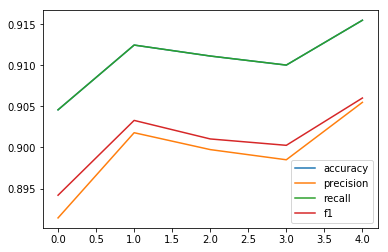

In [494]:
bdpp_logistic = BankDataProcessPipeline(df=bank, classifier=lr)
bdpp_logistic.k_fold_cross_val(fold=5)

#### DecisionTree

The shape of training set is:  (41188, 63) 

Accuracy Score: 0.8827385287691187
Precision Score: 0.8820772653653803
Recall Score: 0.8827385287691187
f1 Score: 0.8824050681074437
confusion_matrix is: 
 [[6833  477]
 [ 489  439]] 



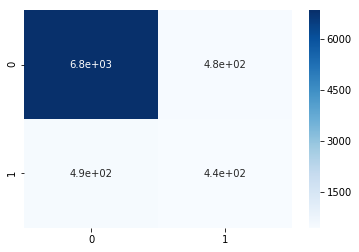

Accuracy Score: 0.8907501820830298
Precision Score: 0.8887094505656569
Recall Score: 0.8907501820830298
f1 Score: 0.8896960350278064
confusion_matrix is: 
 [[6880  430]
 [ 470  458]] 



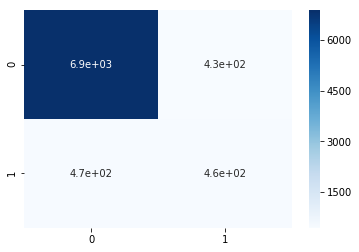

Accuracy Score: 0.8906287933964554
Precision Score: 0.894644290248843
Recall Score: 0.8906287933964554
f1 Score: 0.8925176237849836
confusion_matrix is: 
 [[6821  489]
 [ 412  516]] 



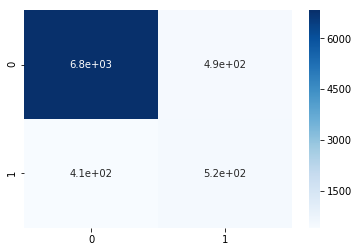

Accuracy Score: 0.8879446400388491
Precision Score: 0.8887369903128507
Recall Score: 0.8879446400388491
f1 Score: 0.8883362688693062
confusion_matrix is: 
 [[6840  469]
 [ 454  474]] 



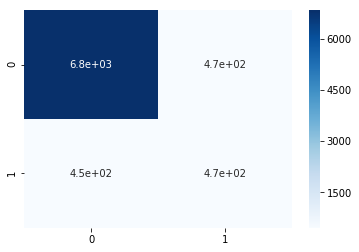

Accuracy Score: 0.8921937598640282
Precision Score: 0.890281492232265
Recall Score: 0.8921937598640282
f1 Score: 0.8912068317130699
confusion_matrix is: 
 [[6884  425]
 [ 463  465]] 



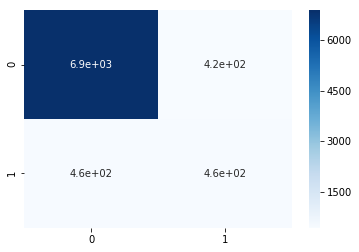

,accuracy,precision,recall,f1
0,0.882739,0.882077,0.882739,0.882405
1,0.890750,0.888709,0.890750,0.889696
2,0.890629,0.894644,0.890629,0.892518
3,0.887945,0.888737,0.887945,0.888336
4,0.892194,0.890281,0.892194,0.891207


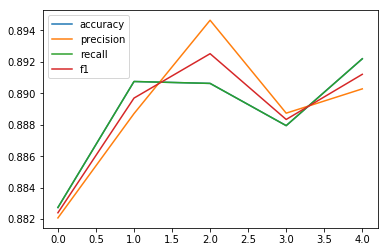

In [517]:
bdpp_dt = BankDataProcessPipeline(df=bank, classifier=dt)
bdpp_dt.k_fold_cross_val(fold=5)

#### MultilayerPerceptron

The shape of training set is:  (41188, 63) 

Accuracy Score: 0.9056809905316825
Precision Score: 0.8968418427014849
Recall Score: 0.9056809905316825
f1 Score: 0.8999494806700428
confusion_matrix is: 
 [[7033  277]
 [ 500  428]] 



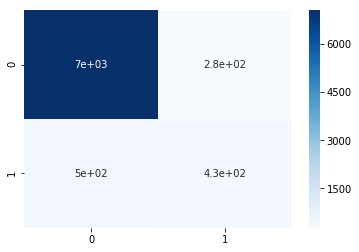

Accuracy Score: 0.9036173828599174
Precision Score: 0.894589943923711
Recall Score: 0.9036173828599174
f1 Score: 0.8978513154498029
confusion_matrix is: 
 [[7023  287]
 [ 507  421]] 



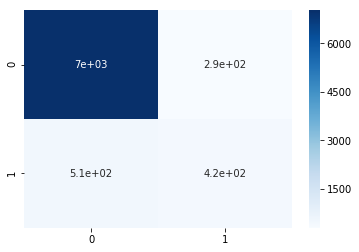

Accuracy Score: 0.8956057295460063
Precision Score: 0.8925137512204806
Recall Score: 0.8956057295460063
f1 Score: 0.8939690465982243
confusion_matrix is: 
 [[6912  398]
 [ 462  466]] 



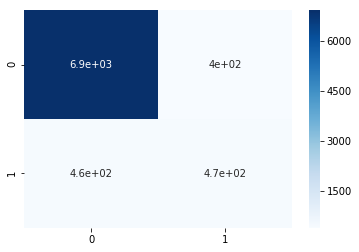

Accuracy Score: 0.8989923515843147
Precision Score: 0.8929841280371901
Recall Score: 0.8989923515843147
f1 Score: 0.8955774358792008
confusion_matrix is: 
 [[6959  350]
 [ 482  446]] 



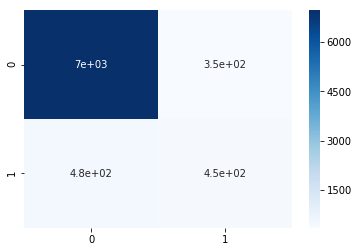

Accuracy Score: 0.8987495447371616
Precision Score: 0.8966815978511835
Recall Score: 0.8987495447371616
f1 Score: 0.8976721585962821
confusion_matrix is: 
 [[6914  395]
 [ 439  489]] 



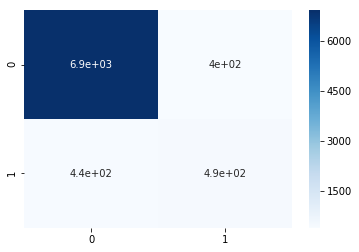

,accuracy,precision,recall,f1
0,0.905681,0.896842,0.905681,0.899949
1,0.903617,0.894590,0.903617,0.897851
2,0.895606,0.892514,0.895606,0.893969
3,0.898992,0.892984,0.898992,0.895577
4,0.898750,0.896682,0.898750,0.897672


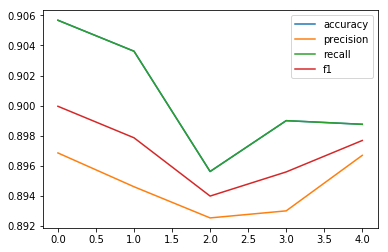

In [502]:
bdpp_mlp = BankDataProcessPipeline(df=bank, classifier=mlp)
bdpp_mlp.k_fold_cross_val(fold=5)

### Balanced Dataset

#### LogisticRegression

In [505]:
bdpp_logistic = BankDataProcessPipeline(df=bank, classifier=lr)

##### Downsample

The shape of training set is:  (41188, 63) 

After downsampling, there are 3712 data entries labeled as yes.
 There are 3712 data entries labeled as no.


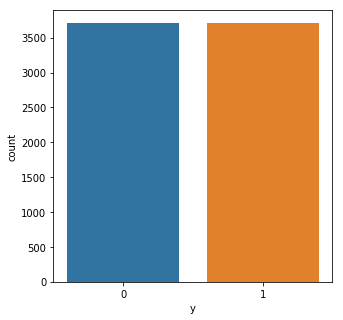

Accuracy Score: 0.8561544064093226
Precision Score: 0.9187909683449437
Recall Score: 0.8561544064093226
f1 Score: 0.8753809330559901
confusion_matrix is: 
 [[6248 1062]
 [ 123  805]] 



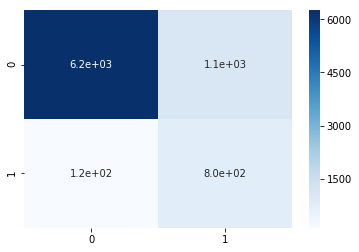

Accuracy Score: 0.8580966253945133
Precision Score: 0.9186882478809587
Recall Score: 0.8580966253945133
f1 Score: 0.8767882618609042
confusion_matrix is: 
 [[6268 1042]
 [ 127  801]] 



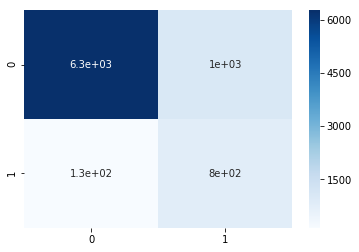

Accuracy Score: 0.8663510560815731
Precision Score: 0.9236642118129516
Recall Score: 0.8663510560815731
f1 Score: 0.883666449975388
confusion_matrix is: 
 [[6315  995]
 [ 106  822]] 



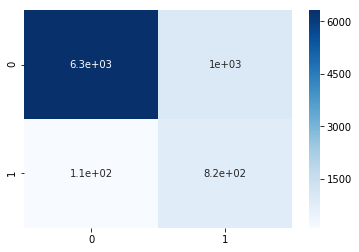

Accuracy Score: 0.8579579944154425
Precision Score: 0.9193560577924251
Recall Score: 0.8579579944154425
f1 Score: 0.8767944211730492
confusion_matrix is: 
 [[6261 1048]
 [ 122  806]] 



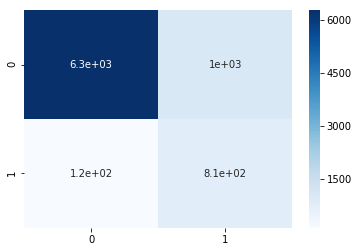

Accuracy Score: 0.8603860628869734
Precision Score: 0.9219200899761449
Recall Score: 0.8603860628869734
f1 Score: 0.8789904666862631
confusion_matrix is: 
 [[6267 1042]
 [ 108  820]] 



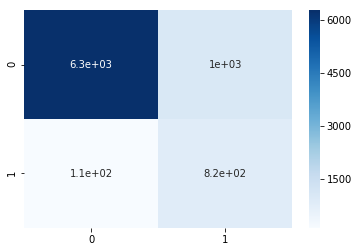

,accuracy,precision,recall,f1
0,0.856154,0.918791,0.856154,0.875381
1,0.858097,0.918688,0.858097,0.876788
2,0.866351,0.923664,0.866351,0.883666
3,0.857958,0.919356,0.857958,0.876794
4,0.860386,0.921920,0.860386,0.878990


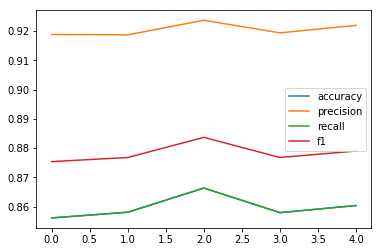

In [506]:
bdpp_logistic.k_fold_cross_val(fold=5, option='downsample')

##### Upsample

The shape of training set is:  (41188, 63) 

After upsampling, there are 29238 data entries labeled as yes.
 There are 29238 data entries labeled as no.


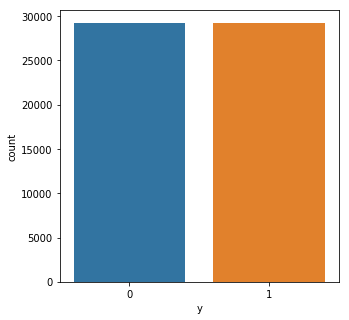

Accuracy Score: 0.8543335761107065
Precision Score: 0.9205137643326631
Recall Score: 0.8543335761107065
f1 Score: 0.8743129605915115
confusion_matrix is: 
 [[6218 1092]
 [ 108  820]] 



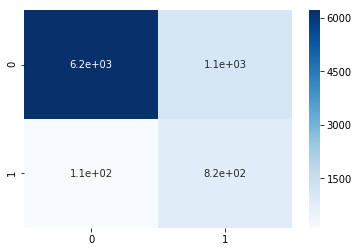

Accuracy Score: 0.8573682932750668
Precision Score: 0.9197890508243036
Recall Score: 0.8573682932750668
f1 Score: 0.8764325707517202
confusion_matrix is: 
 [[6253 1057]
 [ 118  810]] 



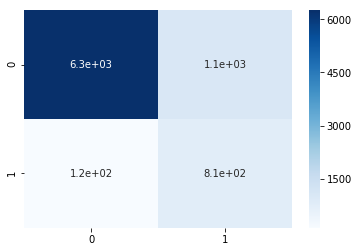

Accuracy Score: 0.8651371692158291
Precision Score: 0.9236425859702262
Recall Score: 0.8651371692158291
f1 Score: 0.8827679068612164
confusion_matrix is: 
 [[6303 1007]
 [ 104  824]] 



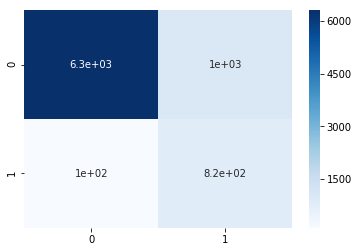

Accuracy Score: 0.8600218526162438
Precision Score: 0.9208421196175186
Recall Score: 0.8600218526162438
f1 Score: 0.8785505500835222
confusion_matrix is: 
 [[6271 1038]
 [ 115  813]] 



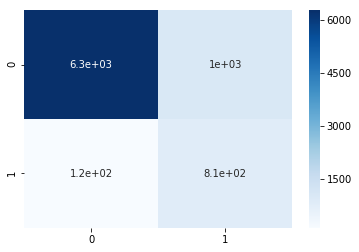

Accuracy Score: 0.8630569382056574
Precision Score: 0.9231283003801376
Recall Score: 0.8630569382056574
f1 Score: 0.8811504727490317
confusion_matrix is: 
 [[6285 1024]
 [ 104  824]] 



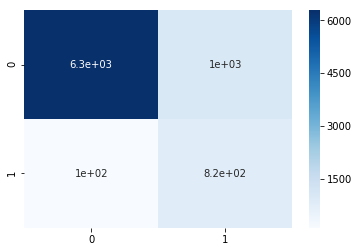

,accuracy,precision,recall,f1
0,0.854334,0.920514,0.854334,0.874313
1,0.857368,0.919789,0.857368,0.876433
2,0.865137,0.923643,0.865137,0.882768
3,0.860022,0.920842,0.860022,0.878551
4,0.863057,0.923128,0.863057,0.881150


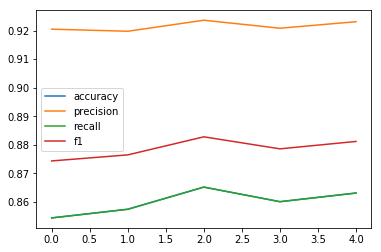

In [507]:
bdpp_logistic.k_fold_cross_val(fold=5, option='upsample')

#### DecisionTree

In [519]:
bdpp_dt = BankDataProcessPipeline(df=bank, classifier=dt)

##### Downsample

The shape of training set is:  (41188, 63) 

After downsampling, there are 3712 data entries labeled as yes.
 There are 3712 data entries labeled as no.


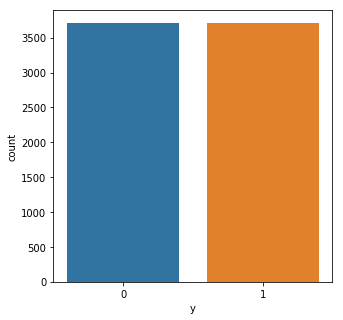

Accuracy Score: 0.8327263899004613
Precision Score: 0.9071732456481321
Recall Score: 0.8327263899004613
f1 Score: 0.8564039349104849
confusion_matrix is: 
 [[6099 1211]
 [ 167  761]] 



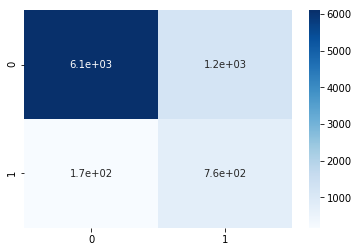

Accuracy Score: 0.8415877640203933
Precision Score: 0.9101288285224747
Recall Score: 0.8415877640203933
f1 Score: 0.863327336370683
confusion_matrix is: 
 [[6165 1145]
 [ 160  768]] 



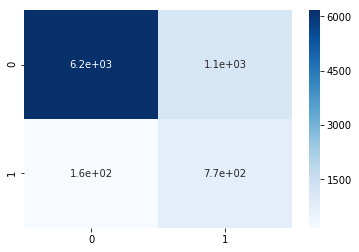

Accuracy Score: 0.8449866472444768
Precision Score: 0.9130619186243183
Recall Score: 0.8449866472444768
f1 Score: 0.8662832052209242
confusion_matrix is: 
 [[6178 1132]
 [ 145  783]] 



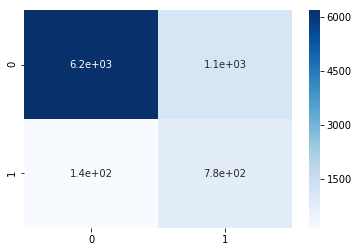

Accuracy Score: 0.8344057302415928
Precision Score: 0.9088469758080471
Recall Score: 0.8344057302415928
f1 Score: 0.8578913330076661
confusion_matrix is: 
 [[6103 1206]
 [ 158  770]] 



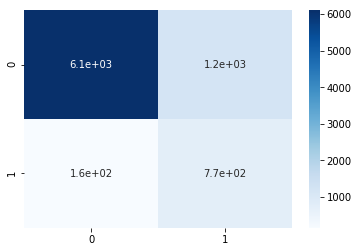

Accuracy Score: 0.8464246691756707
Precision Score: 0.9129477615817472
Recall Score: 0.8464246691756707
f1 Score: 0.8673120381493311
confusion_matrix is: 
 [[6192 1117]
 [ 148  780]] 



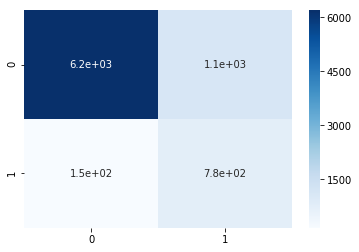

,accuracy,precision,recall,f1
0,0.832726,0.907173,0.832726,0.856404
1,0.841588,0.910129,0.841588,0.863327
2,0.844987,0.913062,0.844987,0.866283
3,0.834406,0.908847,0.834406,0.857891
4,0.846425,0.912948,0.846425,0.867312


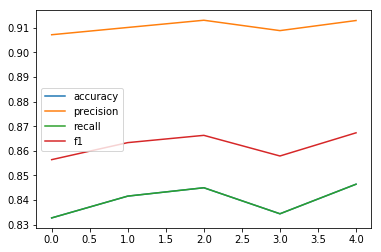

In [520]:
bdpp_dt.k_fold_cross_val(fold=5, option='downsample')

##### Upsample

The shape of training set is:  (41188, 63) 

After upsampling, there are 29238 data entries labeled as yes.
 There are 29238 data entries labeled as no.


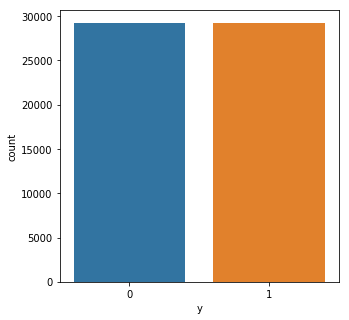

Accuracy Score: 0.8897790725904345
Precision Score: 0.8878214462341062
Recall Score: 0.8897790725904345
f1 Score: 0.8887700193315844
confusion_matrix is: 
 [[6875  435]
 [ 473  455]] 



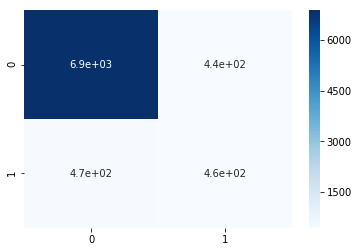

Accuracy Score: 0.8895362952172857
Precision Score: 0.8893285861467487
Recall Score: 0.8895362952172857
f1 Score: 0.8894321111400533
confusion_matrix is: 
 [[6857  453]
 [ 457  471]] 



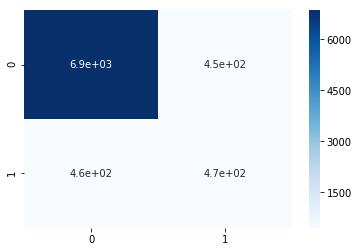

Accuracy Score: 0.8939062879339645
Precision Score: 0.896225194217122
Recall Score: 0.8939062879339645
f1 Score: 0.8950217976761136
confusion_matrix is: 
 [[6850  460]
 [ 414  514]] 



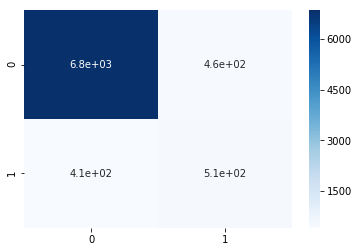

Accuracy Score: 0.8904941119339566
Precision Score: 0.8896722913721129
Recall Score: 0.8904941119339566
f1 Score: 0.8900778631945954
confusion_matrix is: 
 [[6866  443]
 [ 459  469]] 



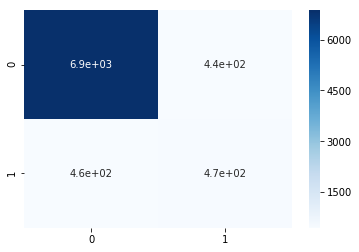

Accuracy Score: 0.8926793735583344
Precision Score: 0.8906768992147036
Recall Score: 0.8926793735583344
f1 Score: 0.8916438611704846
confusion_matrix is: 
 [[6887  422]
 [ 462  466]] 



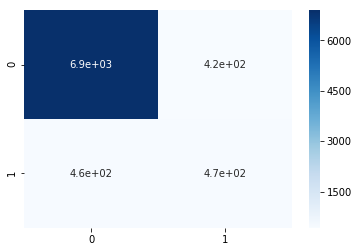

,accuracy,precision,recall,f1
0,0.889779,0.887821,0.889779,0.888770
1,0.889536,0.889329,0.889536,0.889432
2,0.893906,0.896225,0.893906,0.895022
3,0.890494,0.889672,0.890494,0.890078
4,0.892679,0.890677,0.892679,0.891644


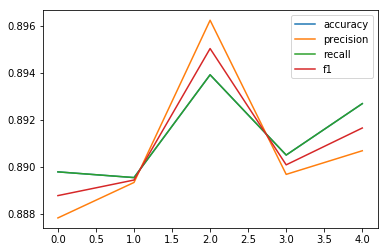

In [521]:
bdpp_dt.k_fold_cross_val(fold=5, option='upsample')

#### MultilayerPerceptron

In [522]:
bdpp_mlp = BankDataProcessPipeline(df=bank, classifier=mlp)

##### Downsample

The shape of training set is:  (41188, 63) 

After downsampling, there are 3712 data entries labeled as yes.
 There are 3712 data entries labeled as no.


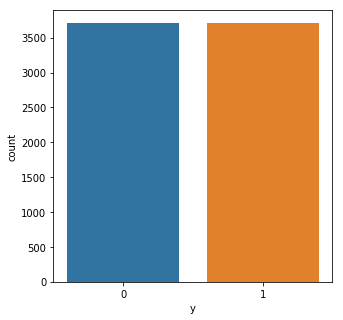

Accuracy Score: 0.835882495751396
Precision Score: 0.9109342837310339
Recall Score: 0.835882495751396
f1 Score: 0.8592971867216641
confusion_matrix is: 
 [[6104 1206]
 [ 146  782]] 



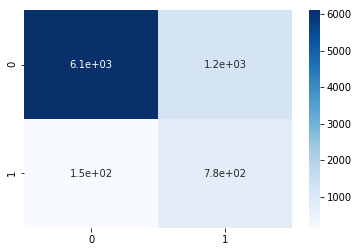

Accuracy Score: 0.8312697256615683
Precision Score: 0.912665235082619
Recall Score: 0.8312697256615683
f1 Score: 0.8561723748107083
confusion_matrix is: 
 [[6048 1262]
 [ 128  800]] 



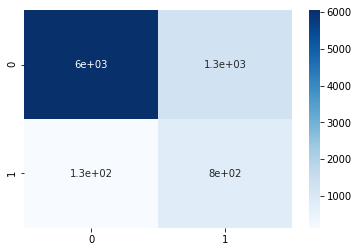

Accuracy Score: 0.8360038844379704
Precision Score: 0.9125850102568863
Recall Score: 0.8360038844379704
f1 Score: 0.8596373018118139
confusion_matrix is: 
 [[6094 1216]
 [ 135  793]] 



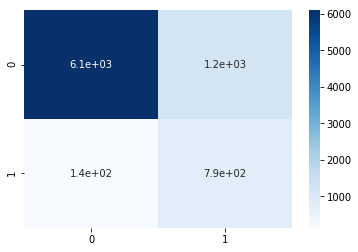

Accuracy Score: 0.8351341507830521
Precision Score: 0.9107697144852961
Recall Score: 0.8351341507830521
f1 Score: 0.8587230444625121
confusion_matrix is: 
 [[6097 1212]
 [ 146  782]] 



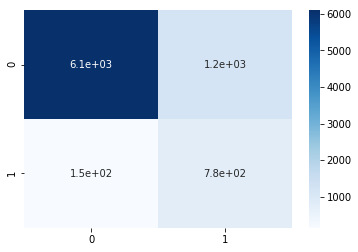

Accuracy Score: 0.8352555542066287
Precision Score: 0.9191649421507982
Recall Score: 0.8352555542066287
f1 Score: 0.8600081380928489
confusion_matrix is: 
 [[6042 1267]
 [  90  838]] 



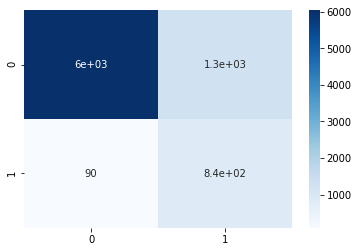

,accuracy,precision,recall,f1
0,0.835882,0.910934,0.835882,0.859297
1,0.831270,0.912665,0.831270,0.856172
2,0.836004,0.912585,0.836004,0.859637
3,0.835134,0.910770,0.835134,0.858723
4,0.835256,0.919165,0.835256,0.860008


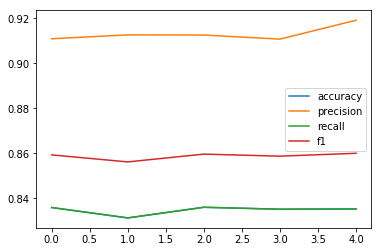

In [523]:
bdpp_mlp.k_fold_cross_val(fold=5, option='downsample')

##### Upsample

The shape of training set is:  (41188, 63) 

After upsampling, there are 29238 data entries labeled as yes.
 There are 29238 data entries labeled as no.


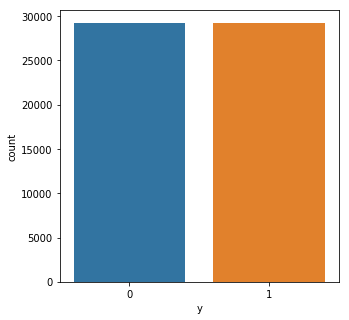

Accuracy Score: 0.8828599174556931
Precision Score: 0.899596348420907
Recall Score: 0.8828599174556931
f1 Score: 0.8896863814266509
confusion_matrix is: 
 [[6680  630]
 [ 335  593]] 



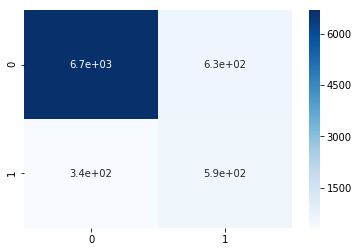

Accuracy Score: 0.8732702112163147
Precision Score: 0.9050508609297673
Recall Score: 0.8732702112163147
f1 Score: 0.8848333962044147
confusion_matrix is: 
 [[6527  783]
 [ 261  667]] 



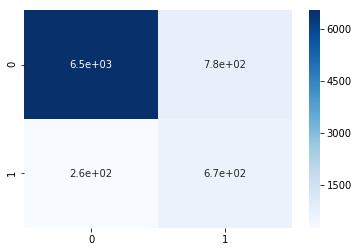

Accuracy Score: 0.8850449138140325
Precision Score: 0.9064973455380118
Recall Score: 0.8850449138140325
f1 Score: 0.8932619978931923
confusion_matrix is: 
 [[6647  663]
 [ 284  644]] 



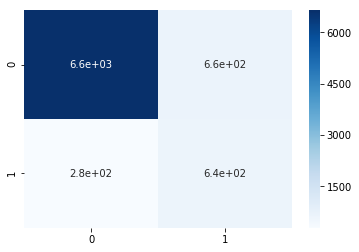

Accuracy Score: 0.8708267573145563
Precision Score: 0.9014271494338775
Recall Score: 0.8708267573145563
f1 Score: 0.8822124536817125
confusion_matrix is: 
 [[6528  781]
 [ 283  645]] 



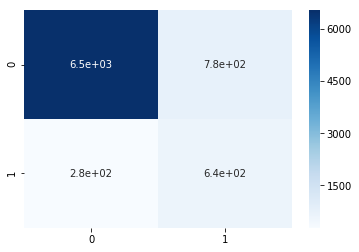

Accuracy Score: 0.886366395532354
Precision Score: 0.8984650212256486
Recall Score: 0.886366395532354
f1 Score: 0.8915192888829724
confusion_matrix is: 
 [[6731  578]
 [ 358  570]] 



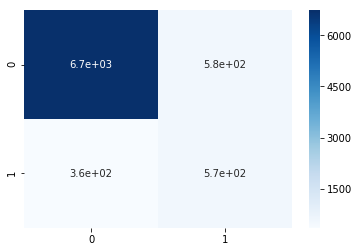

,accuracy,precision,recall,f1
0,0.882860,0.899596,0.882860,0.889686
1,0.873270,0.905051,0.873270,0.884833
2,0.885045,0.906497,0.885045,0.893262
3,0.870827,0.901427,0.870827,0.882212
4,0.886366,0.898465,0.886366,0.891519


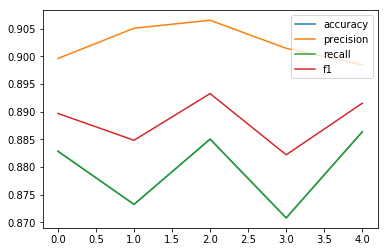

In [524]:
bdpp_mlp.k_fold_cross_val(fold=5, option='upsample')